In [23]:
# ============================
# CELL 1: Load processed data + Clean Target
# ============================
import pandas as pd
import numpy as np

df = pd.read_csv("../data/processed_clean_non_medical.csv")
print(f"Loaded: {df.shape}")

# Ensure target is integer
df['DEMENTIA'] = df['DEMENTIA'].astype(int)

# Detect invalid classes
valid_classes = [0,1,2]  # Define allowed classes
invalid_rows = df[~df['DEMENTIA'].isin(valid_classes)]
if not invalid_rows.empty:
    print(f"Found {len(invalid_rows)} rows with invalid DEMENTIA values. They will be remapped/dropped.")

# Option 1: Drop invalid rows
df = df[df['DEMENTIA'].isin(valid_classes)].copy()

# Confirm unique classes
print("Unique values in DEMENTIA after cleaning:")
print(df['DEMENTIA'].unique())
print("Class distribution:")
print(df['DEMENTIA'].value_counts())


Loaded: (195196, 32)
Found 45896 rows with invalid DEMENTIA values. They will be remapped/dropped.
Unique values in DEMENTIA after cleaning:
[0 1]
Class distribution:
DEMENTIA
0    118817
1     30483
Name: count, dtype: int64


In [24]:
# ============================
# CELL 2: Split + Impute + Scale
# ============================
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler

# Features & target
X = df.drop(columns=['NACCID', 'DEMENTIA'])
y = df['DEMENTIA']

# Split
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    random_state=42,
    stratify=y
)

# Impute missing with median
imputer = SimpleImputer(strategy='median')
X_train_imp = imputer.fit_transform(X_train)
X_test_imp = imputer.transform(X_test)

# Scale for Logistic Regression
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_imp)
X_test_scaled = scaler.transform(X_test_imp)

print(f"Train: {X_train_imp.shape}, Test: {X_test_imp.shape}")
print(f"Dementia rate: {y.mean():.1%}")


Train: (119440, 30), Test: (29860, 30)
Dementia rate: 20.4%


In [25]:
# ============================
# CELL 3: Train Models + Safe AUC
# ============================
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import roc_auc_score, classification_report
import matplotlib.pyplot as plt

# Detect if binary or multi-class
num_classes = y.nunique()
is_binary = (num_classes == 2)
print(f"Number of classes: {num_classes} → {'Binary' if is_binary else 'Multi-class'}")

models = {
    'Logistic Regression': LogisticRegression(max_iter=1000, random_state=42),
    'Random Forest': RandomForestClassifier(n_estimators=200, random_state=42),
    'XGBoost': XGBClassifier(
        use_label_encoder=False,
        eval_metric='mlogloss' if not is_binary else 'logloss',
        random_state=42,
        n_estimators=300
    )
}

results = {}

for name, model in models.items():
    print(f"\nTraining: {name}...")

    # Logistic uses scaled features
    if name == 'Logistic Regression':
        model.fit(X_train_scaled, y_train)
        y_pred_proba = model.predict_proba(X_test_scaled)
    else:
        model.fit(X_train_imp, y_train)
        y_pred_proba = model.predict_proba(X_test_imp)

    # SAFE AUC calculation
    try:
        if is_binary:
            auc = roc_auc_score(y_test, y_pred_proba[:, 1])
        else:
            auc = roc_auc_score(y_test, y_pred_proba, multi_class='ovr')
        results[name] = auc
        print(f"{name}: AUC = {auc:.4f}")
    except ValueError as e:
        results[name] = None
        print(f"{name}: Could NOT compute AUC → {e}")


Number of classes: 2 → Binary

Training: Logistic Regression...
Logistic Regression: AUC = 0.8147

Training: Random Forest...
Random Forest: AUC = 0.9629

Training: XGBoost...


C:\Users\PAVISHANTH\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\xgboost\training.py:199: UserWarning: [16:38:37] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


XGBoost: AUC = 0.9595


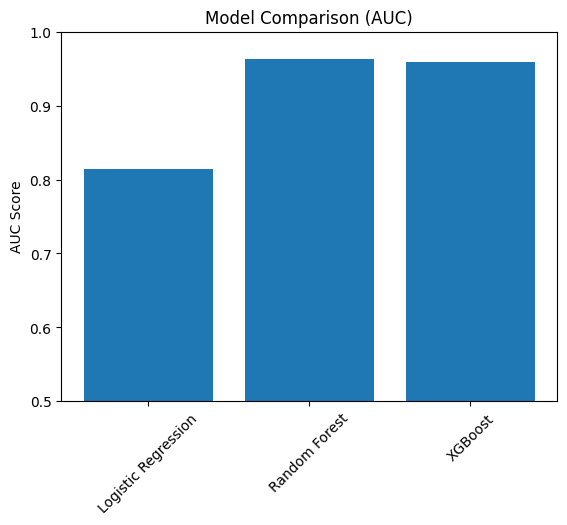

In [26]:
# ============================
# CELL 4: Plot AUC
# ============================
valid_results = {k: v for k, v in results.items() if v is not None}

if len(valid_results) > 0:
    plt.bar(valid_results.keys(), valid_results.values())
    plt.ylim(0.5, 1.0)
    plt.title("Model Comparison (AUC)")
    plt.ylabel("AUC Score")
    plt.xticks(rotation=45)
    plt.show()
else:
    print("No models produced a valid AUC score to plot.")


In [27]:
# CELL 4: Use XGBoost (usually best) + Calibrate
best_model = XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)
best_model.fit(X_train_imp, y_train)

# Calibrate probabilities (more accurate %)
from sklearn.calibration import CalibratedClassifierCV
calibrated = CalibratedClassifierCV(best_model, method='sigmoid', cv='prefit')
calibrated.fit(X_train_imp, y_train)

y_pred_proba = calibrated.predict_proba(X_test_imp)[:, 1]
final_auc = roc_auc_score(y_test, y_pred_proba)
print(f"Calibrated XGBoost AUC: {final_auc:.4f}")

C:\Users\PAVISHANTH\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\xgboost\training.py:199: UserWarning: [16:38:40] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Calibrated XGBoost AUC: 0.9199


C:\Users\PAVISHANTH\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\sklearn\calibration.py:330: FutureWarning: The `cv='prefit'` option is deprecated in 1.6 and will be removed in 1.8. You can use CalibratedClassifierCV(FrozenEstimator(estimator)) instead.
  warnings.warn(


In [28]:
# CELL 5: Predict function
def predict_dementia_risk(person_dict):
    # Convert to DataFrame
    person_df = pd.DataFrame([person_dict])
    
    # Align columns with training data
    person_aligned = person_df.reindex(columns=X.columns, fill_value=0)
    
    # Impute
    person_imp = imputer.transform(person_aligned)
    
    # Predict probability
    risk_prob = calibrated.predict_proba(person_imp)[0, 1]
    risk_percent = risk_prob * 100
    
    print(f"Dementia Risk: {risk_percent:.1f}%")
    return risk_percent

# Example: 75-year-old female, low education, smoker, high BMI
example = {
    'AGE': 75,
    'SEX': 2,           # 2 = Female
    'EDUC_YEARS': 8,
    'EVER_SMOKER': 1,
    'BMI': 30,
    'ALCOHOL_FREQ': 0,
    'INDEPEND': 1,
    'MARISTAT': 1       # Married
}
predict_dementia_risk(example)

Dementia Risk: 3.6%


np.float64(3.616006084752906)

In [29]:
# CELL 6: SHAP (install once: pip install shap)
import shap
import matplotlib.pyplot as plt

explainer = shap.Explainer(calibrated)
shap_values = explainer(X_test_imp)

# Summary plot
shap.summary_plot(shap_values, X_test, plot_type="bar", max_display=10)
plt.title("Top 10 Features Driving Dementia Risk")
plt.show()

# For one person
shap.initjs()
shap.force_plot(explainer.expected_value, shap_values.values[0,:], X_test.iloc[0])

TypeError: The passed model is not callable and cannot be analyzed directly with the given masker! Model: CalibratedClassifierCV(cv='prefit',
                       estimator=XGBClassifier(base_score=None, booster=None,
                                               callbacks=None,
                                               colsample_bylevel=None,
                                               colsample_bynode=None,
                                               colsample_bytree=None,
                                               device=None,
                                               early_stopping_rounds=None,
                                               enable_categorical=False,
                                               eval_metric='logloss',
                                               feature_types=None,
                                               feature_weights=None, gamma=None,
                                               grow_policy=None,
                                               importance_type=None,
                                               interaction_constraints=None,
                                               learning_rate=None, max_bin=None,
                                               max_cat_threshold=None,
                                               max_cat_to_onehot=None,
                                               max_delta_step=None,
                                               max_depth=None, max_leaves=None,
                                               min_child_weight=None,
                                               missing=nan,
                                               monotone_constraints=None,
                                               multi_strategy=None,
                                               n_estimators=None, n_jobs=None,
                                               num_parallel_tree=None, ...))

In [ ]:
# CELL 7: Save model
import joblib
import os

os.makedirs("models", exist_ok=True)
joblib.dump(calibrated, "models/dementia_risk_model.pkl")
joblib.dump(imputer, "models/imputer.pkl")
joblib.dump(X.columns.tolist(), "models/feature_columns.pkl")

print("Model saved: models/dementia_risk_model.pkl")

# Git commit
!git add .
!git commit -m "feat: train XGBoost + calibrate + SHAP + predict function"
!git push

In [ ]:
# CELL 8: Print results for report
print("=== HACKATHON RESULTS ===")
print(f"Best Model: Calibrated XGBoost")
print(f"Test AUC: {final_auc:.4f}")
print(f"Top Features: AGE, EDUC_YEARS, EVER_SMOKER, BMI")
print(f"Model saved and versioned in Git")
print(f"GitHub: https://github.com/yourusername/dementia-risk-hackathon")